In [77]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
import sklearn as sk
from tqdm import tqdm
import tensorflow as tf
from utils import *
import scipy as sc

In [78]:

# Set the path to the folder containing the image data
data_path = '../dataset/input_resized_256/flowers/'
IMG_SIZE=64
# Create an instance of the DimReductionEvaluation class
dre = DimReductionEvaluation()
dre.load_data(data_path, IMG_SIZE)


In [74]:
# Range of K values to test
k_range=np.linspace(1, 700, 25).astype(np.int64)

# Number of samples to use
N=300
pca=PCA(dre.X_flaten, n_components_max=k_range[-1])
sample=np.array([x for x in dre.data.sample(2*N)
                 ['numpy_grayscale_normalized'].to_numpy()])

def calculate_reduction_error(sample, r_space_dim_range):
    error_RP=[]
    error_SRP=[]
    error_PCA=[]
    x1=sample[:N]
    x2=sample[N:]
    for k in tqdm(r_space_dim_range):

        # Linear Projection for the currnet k
        RP_=GaussianRandomProjection(n_components=k)
        RP_.fit(x1)
        RP=RP_.transform
        SRP_=SparseRandomProjection(n_components=k)
        SRP_.fit(x1)
        SRP=SRP_.transform
        # Calculate the reconstruction error        
        d=np.linalg.norm(x1-x2, axis=1)
        d_RP=np.linalg.norm(RP(x1)-RP(x2), axis=1)*np.sqrt(x1.shape[1]/k)
        d_SRP=np.linalg.norm(SRP(x1)-SRP(x2), axis=1)*np.sqrt(x1.shape[1]/k)
        d_PCA=np.linalg.norm(pca.transform(x1, k)-pca.transform(x2, k), axis=-1)

        error_SRP.append((d-d_SRP))
        error_RP.append((d-d_RP))
        error_PCA.append((d-d_PCA))

    error_RP=np.array(error_RP)
    error_SRP=np.array(error_SRP)
    error_PCA=np.array(error_PCA)
    error={'RP': error_RP, 'SRP': error_SRP, 'PCA': error_PCA}
    return error

error=calculate_reduction_error(sample, k_range)


  0%|          | 0/25 [00:00<?, ?it/s]


ValueError: X has 4096 features, but PCA is expecting 12288 features as input.

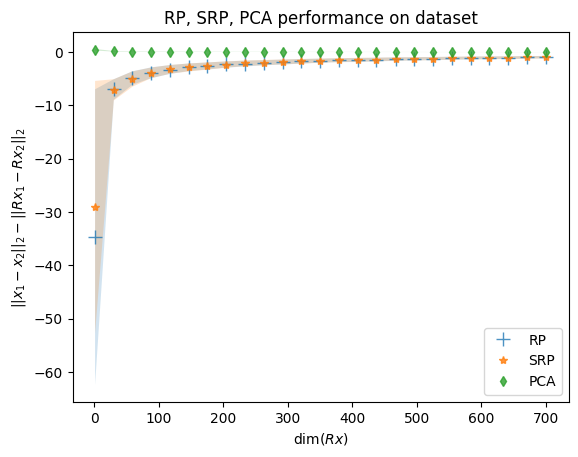

In [58]:
#Making nice plot
%matplotlib inline
def plot_reduction_error(error, ax):
        for error, plot_style, markersize, linewidth, label in zip(error.values(),
                                ['+', '*', 'd'], [10, 6, 5], [10, 10, 2], error.keys()):
                                
                ax.plot(k_range, error.mean(axis=-1), plot_style, markersize=markersize,
                        linewidth=linewidth, label=label, alpha=0.8)
                ax.fill_between(k_range, error.mean(axis=-1) - error.std(axis=-1),
                                error.mean(axis=-1) + error.std(axis=-1), alpha=0.2)

        # ax.legend(loc='best')
        ax.legend(loc='lower right')#, bbox_to_anchor=(1.2, 1.0))
        ax.set_xlabel(r'dim($Rx$)')
        ax.set_ylabel(r'$|| x_1 - x_2 ||_2-|| Rx_1 - Rx_2||_2$')
        ax.set_title('RP, SRP, PCA performance on dataset')
fig, ax = plt.subplots()
plot_reduction_error(error, ax)
plt.show()
# (d1-d2).mean()


In [81]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

# Range of K values to test
k_range=(np.linspace(0.001, 0.05, 10)*dre.dim).astype(np.int64)

# Split the data into training and test sets
x_train, x_test, y_train, y_test = dre.split_data(dre.X_flaten, dre.Y, test_size=0.1)

# Create a KNN classifier
params = {
        "n_neighbors":
        [i for i in range(1, int(np.sqrt(x_train.shape[0])))]
}
random_search = RandomizedSearchCV(
    KNeighborsClassifier(),
    param_distributions=params,
    n_iter=60,
    cv=5,
    n_jobs=-1
    )

# Fit the k-NN classifier to the training data
random_search.fit(x_train, y_train)
baseline=random_search.score(x_test, y_test)
print('Baseline accuracy: ', baseline)

# Create PCA instance and fit it to the training data
pca=PCA(x_train, n_components_max=k_range[-1])

# Test the performance of the different dimensionality reduction methods
accuracy_RP=[]
accuracy_SRP=[]
accuracy_PCA=[]
accuracy_DAE=[]

# Make 5 runs
for i in range(5):
    accuracy_RP_=[]
    accuracy_SRP_=[]
    accuracy_PCA_=[]
    accuracy_DAE_=[]
    # Test the performance for different k values
    for k in tqdm(k_range):

        # Linear Projection for the currnet k
        RP_=GaussianRandomProjection(n_components=k)
        RP_.fit(x_train)
        random_search.fit(RP_.transform(x_train), y_train)
        accuracy_RP_.append(random_search.score(RP_.transform(x_test), y_test))

        SRP_=SparseRandomProjection(n_components=k)
        SRP_.fit(x_train)
        random_search.fit(SRP_.transform(x_train), y_train)
        accuracy_SRP_.append(random_search.score(SRP_.transform(x_test), y_test))

        random_search.fit(pca.transform(x_train, k), y_train)
        accuracy_PCA_.append(random_search.score(pca.transform(x_test, k), y_test))
    
    accuracy_RP.append(accuracy_RP_)
    accuracy_SRP.append(accuracy_SRP_)
    accuracy_PCA.append(accuracy_PCA_)

accuracy_RP=np.array(accuracy_RP)
accuracy_SRP=np.array(accuracy_SRP)
accuracy_PCA=np.array(accuracy_PCA)
accuracy={'RP': accuracy_RP, 'SRP': accuracy_SRP, 'PCA': accuracy_PCA}

Baseline accuracy:  0.33564814814814814


 10%|█         | 1/10 [01:57<17:33, 117.05s/it]


ValueError: n_components=8301 must be between 0 and min(n_samples, n_features)=3885 with svd_solver='full'

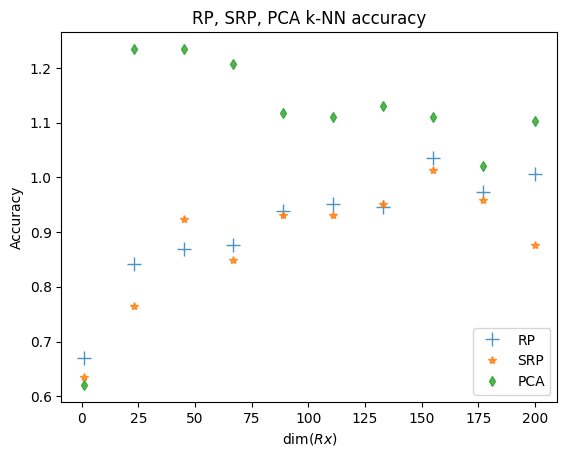

In [65]:

#Making nice plot
%matplotlib inline

accuracy={'RP': accuracy_RP, 'SRP': accuracy_SRP, 'PCA': accuracy_PCA}
fig, ax = plt.subplots()
for accuracy_, plot_style, markersize, linewidth, label in zip(accuracy.values(),
                                ['+', '*', 'd'], [10, 6, 5], [10, 10, 2], accuracy.keys()):
                                
                ax.plot(k_range, accuracy_/baseline, plot_style, markersize=markersize,
                        linewidth=linewidth, label=label, alpha=0.8)

# ax.legend(loc='best')
ax.legend(loc='lower right')#, bbox_to_anchor=(1.2, 1.0))
ax.set_xlabel(r'dim($Rx$)')
ax.set_ylabel('Accuracy')
ax.set_title('RP, SRP, PCA k-NN accuracy')
plt.show()
# (d1-d2).mean()
